In [32]:
import os
import json
import matplotlib.pyplot as plt
import re 

In [14]:
logs_dir = 'logs'

In [33]:
# Function to extract the desired metrics from a JSON file
def extract_metrics(json_file):
    metrics = {
        'acceptance_rate': None,
        'total_time': None,
        'time_per_token': None,
        'tokens_per_second': None
    }
    
    with open(json_file, 'r') as f:
        try:
            data = json.load(f)
            metrics['acceptance_rate'] = data.get('acceptance_rate', {}).get('mean')
            metrics['total_time'] = data.get('total_time', {}).get('mean')
            metrics['time_per_token'] = data.get('time_per_token', {}).get('mean')
            metrics['tokens_per_second'] = data.get('tokens_per_second', {}).get('mean')
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in {json_file}: {e}")
            return None
    
    return metrics

def extract_number_from_subfolder_name(subfolder_name):
    match = re.search(r'(\d+)B$', subfolder_name)  # Extract the number before 'B'
    if match:
        return int(match.group(1))
    return float('inf')

    
# Function to plot the bar graphs for each subfolder
def plot_bar_graphs(metric_data):
    # Prepare the data for plotting
    for metric_name, data in metric_data.items():
        subfolders = list(data.keys())
        subfolders.sort(key=extract_number_from_subfolder_name)
        
        # Get the corresponding metric values for the sorted subfolders
        values = [data[subfolder] for subfolder in subfolders]
        
        plt.figure(figsize=(10, 6))
        plt.bar(subfolders, values, color='skyblue')
        plt.xlabel('Subfolder Name')
        plt.ylabel(metric_name)
        plt.title(f'{metric_name} across subfolders')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()



# Function to process all the .json files and extract the metrics
def process_logs(logs_dir):
    # Store the extracted data for plotting
    metric_data = {
        'acceptance_rate': {},
        'total_time': {},
        'time_per_token': {},
        'tokens_per_second': {}
    }

    # Walk through the logs directory
    for subdir, dirs, files in os.walk(logs_dir):
        eval_files = [file for file in files if file.endswith(".json") and file.startswith("eval_")]
        
        # If there are any eval files in the subdirectory, find the one with the largest first and second values
        if eval_files:
            eval_files.sort(key=lambda x: (int(x.split('_')[1]), int(x.split('_')[2].split('.')[0])), reverse=True)
            best_file = eval_files[0]

            # Extract the metrics from the best file
            json_file_path = os.path.join(subdir, best_file)
            metrics = extract_metrics(json_file_path)

            if metrics:
                subfolder_name = os.path.basename(subdir)  # Use the subfolder name as the key
                # Store the metrics for the subfolder
                for metric_name in metric_data:
                    if metrics.get(metric_name) is not None:
                        metric_data[metric_name][subfolder_name] = metrics[metric_name]

    # Plot the bar graphs for each metric
    plot_bar_graphs(metric_data)

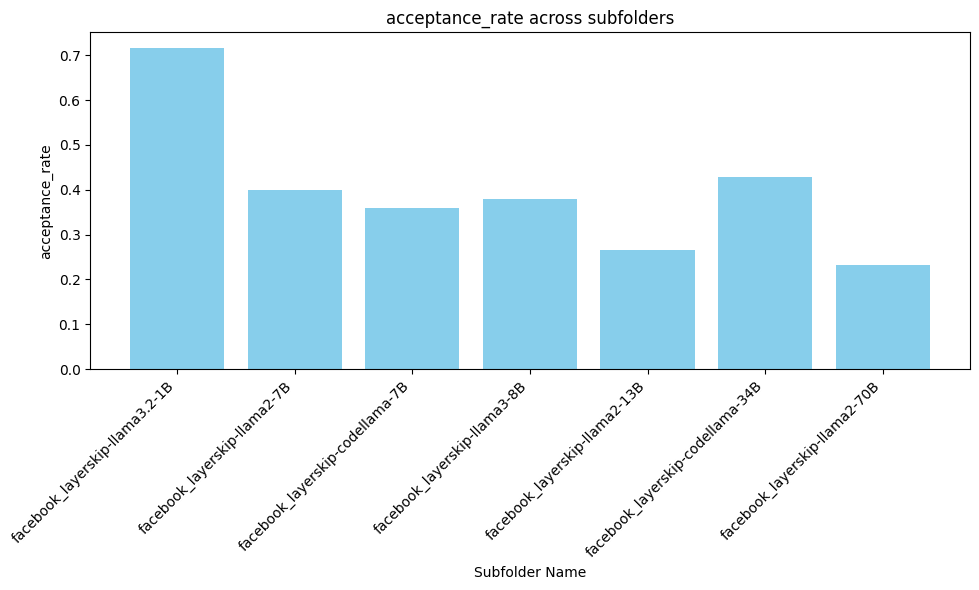

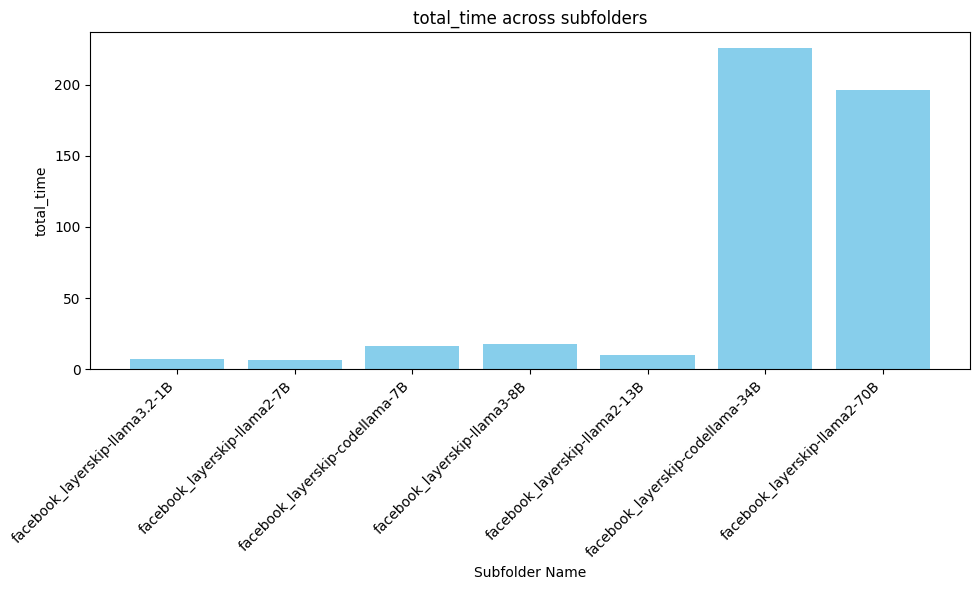

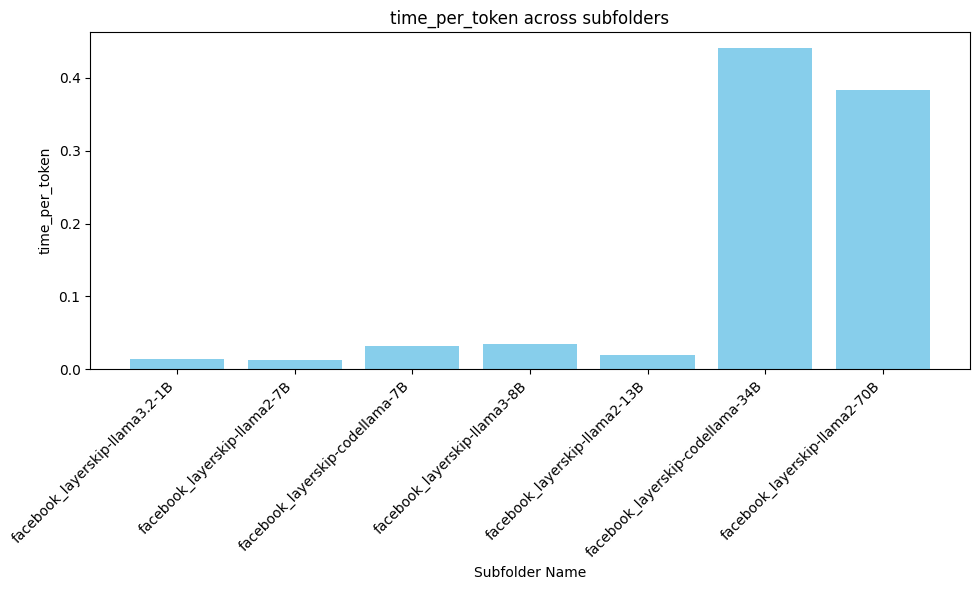

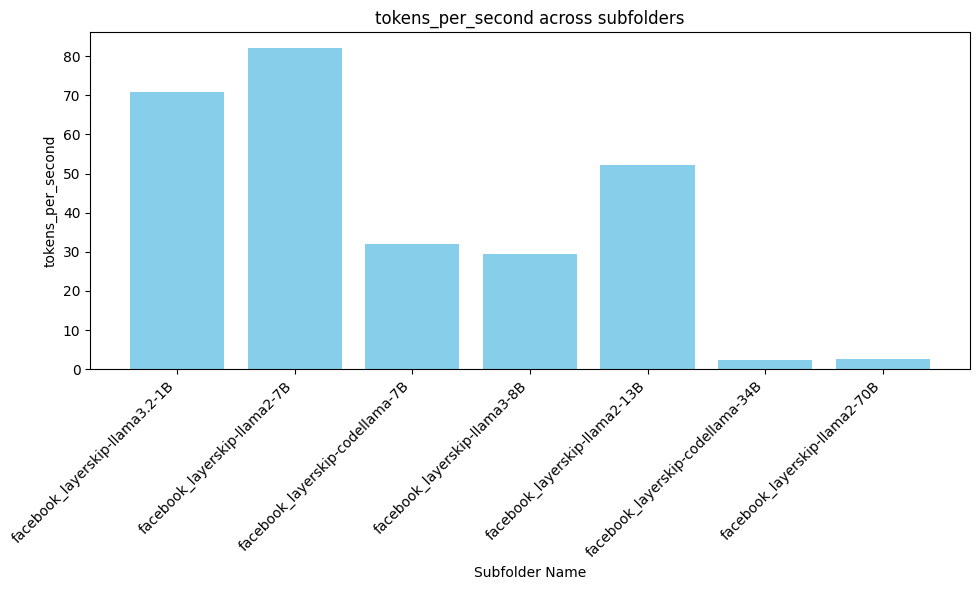

In [34]:
process_logs(logs_dir)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re

In [12]:
# Find all CSV files starting with 'benchmark_results'
csv_files = glob.glob("benchmark_results_*.csv")

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    # Extract model name from filename
    model_name = re.search(r'benchmark_results_(.*)\.csv', os.path.basename(file)).group(1)
    df['model'] = model_name  # Add a new column for the model
    dfs.append(df)

# Combine into one DataFrame
data = pd.concat(dfs, ignore_index=True)

# Display the data structure
print(data.head())

# Set Seaborn style
sns.set(style="whitegrid")


   early_exit  auto_total_time  auto_avg_time  auto_tokens_per_sec  \
0           2        97.147069      19.429414            22.131393   
1           4        79.631348      15.926270            22.064175   
2           6        76.067571      15.213514            21.139100   
3           8        46.083324       9.216665            22.329118   
4          10        81.284642      16.256928            21.357048   

   spec_total_time  spec_avg_time  spec_tokens_per_sec       model  
0        98.196068      19.639214            21.518173  llama2-13B  
1       117.967009      23.593402            21.005873  llama2-13B  
2        57.853275      11.570655            23.507745  llama2-13B  
3        48.740492       9.748098            26.528251  llama2-13B  
4        48.877092       9.775418            31.916792  llama2-13B  


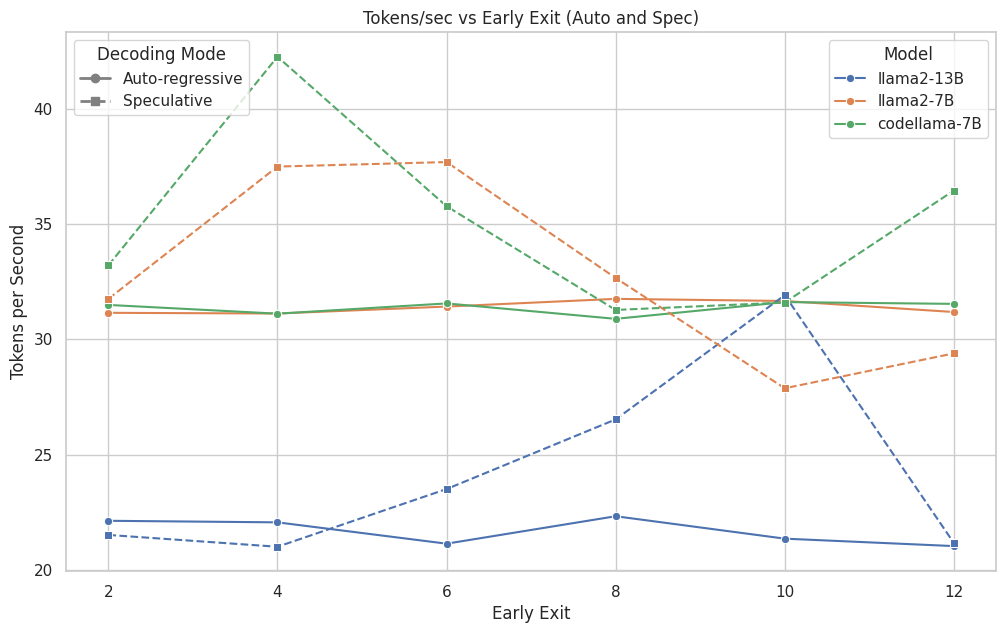

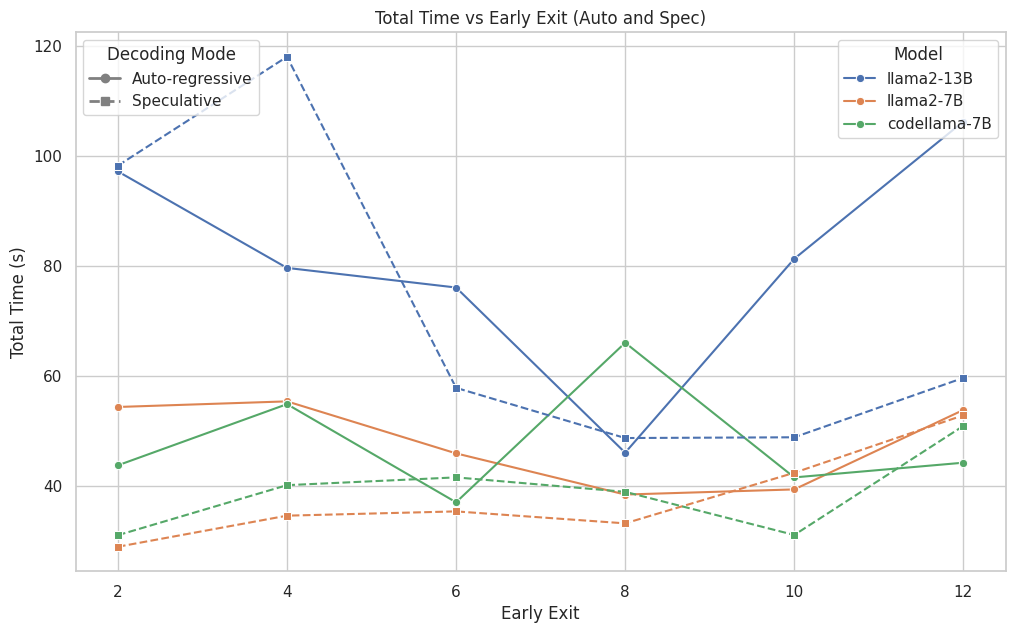

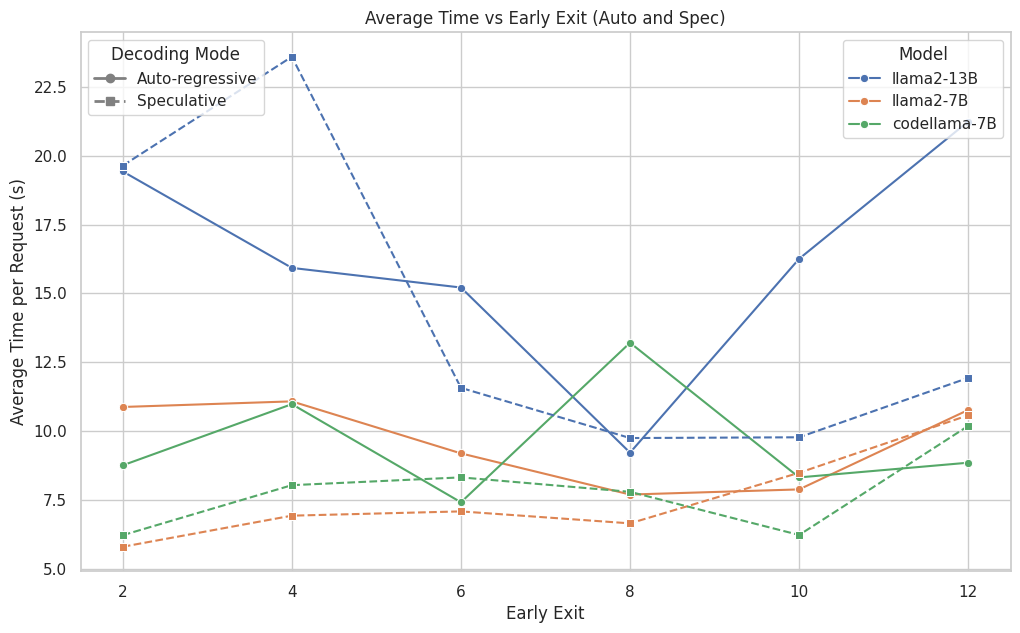

In [20]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray', lw=2, marker='o', label='Auto-regressive'),
                Line2D([0], [0], color='gray', lw=2, marker='s', linestyle='--', label='Speculative')]

# --- Visualization 1: Tokens per Second vs Early Exit ---
plt.figure(figsize=(12, 7))
sns.lineplot(data=data, x='early_exit', y='auto_tokens_per_sec', hue='model', marker='o')
sns.lineplot(data=data, x='early_exit', y='spec_tokens_per_sec', hue='model', marker='s', linestyle='--', legend=False)
plt.xlabel('Early Exit')
plt.ylabel('Tokens per Second')
plt.title('Tokens/sec vs Early Exit (Auto and Spec)')
ax = plt.gca()

# Store the first legend (model) and add it to the plot
first_legend = ax.legend(title='Model', loc='upper right')
ax.add_artist(first_legend)  # This preserves the first legend

# Add the second legend (decoding mode)
ax.legend(handles=custom_lines, title='Decoding Mode', loc='upper left')
plt.grid(True)
plt.show()

# --- Visualization 2: Total Time vs Early Exit ---
plt.figure(figsize=(12, 7))
sns.lineplot(data=data, x='early_exit', y='auto_total_time', hue='model', marker='o')
sns.lineplot(data=data, x='early_exit', y='spec_total_time', hue='model', marker='s', linestyle='--', legend=False)
plt.xlabel('Early Exit')
plt.ylabel('Total Time (s)')
plt.title('Total Time vs Early Exit (Auto and Spec)')
ax = plt.gca()

# Store the first legend (model) and add it to the plot
first_legend = ax.legend(title='Model', loc='upper right')
ax.add_artist(first_legend)  # This preserves the first legend

# Add the second legend (decoding mode)
ax.legend(handles=custom_lines, title='Decoding Mode', loc='upper left')
plt.grid(True)
plt.show()

# --- Visualization 3: Average Time vs Early Exit ---
plt.figure(figsize=(12, 7))
sns.lineplot(data=data, x='early_exit', y='auto_avg_time', hue='model', marker='o')
sns.lineplot(data=data, x='early_exit', y='spec_avg_time', hue='model', marker='s', linestyle='--', legend=False)
plt.xlabel('Early Exit')
plt.ylabel('Average Time per Request (s)')
plt.title('Average Time vs Early Exit (Auto and Spec)')
ax = plt.gca()

# Store the first legend (model) and add it to the plot
first_legend = ax.legend(title='Model', loc='upper right')
ax.add_artist(first_legend)  # This preserves the first legend

# Add the second legend (decoding mode)
ax.legend(handles=custom_lines, title='Decoding Mode', loc='upper left')
plt.grid(True)
plt.show()